# Define Forecasting
Forecasting is a technique that uses historical data as inputs to make informed estimates that are predictive in determining the direction of future trends. It's a planning tool that helps management in its attempts to cope with the uncertainty of the future, relying mainly on data from the past and present and analysis of trends. Forecasting is used in various areas such as weather prediction, sales projection, stock market trends, and many more. In the context of time series data, forecasting is often associated with making predictions about the future based on time-dependent data.

In [ ]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR

np.random.seed(0)

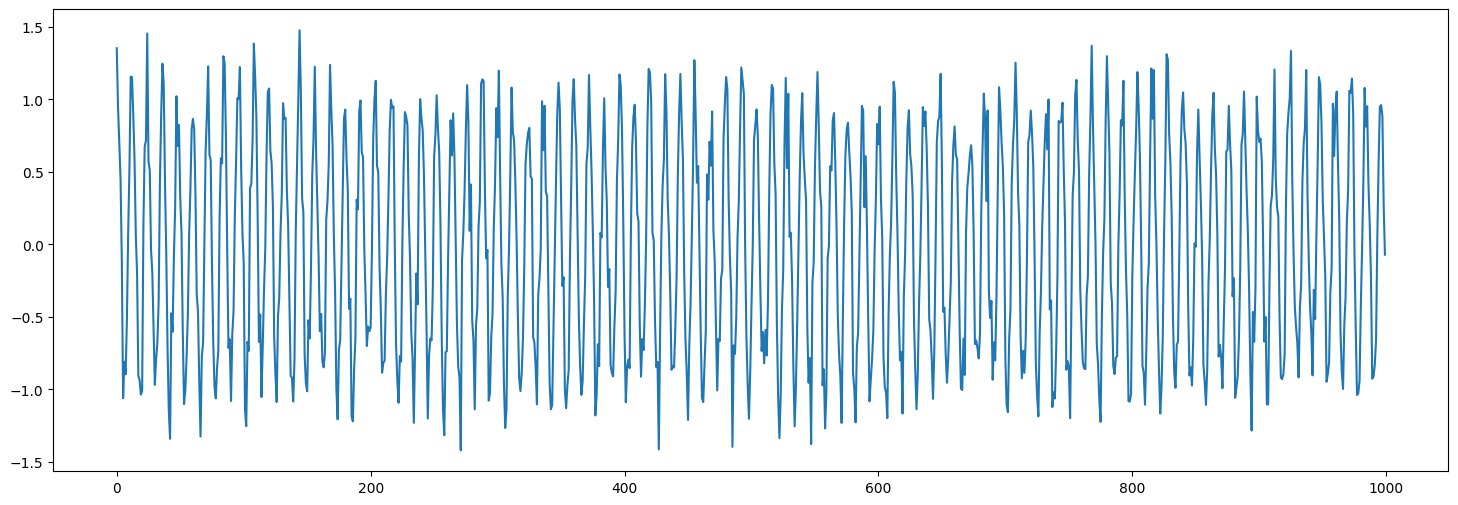

In [2]:
n_samples = 1000  # Number of samples in the time series
seasonality_period = 12  # Period of the cosine seasonality
noise_std = 0.2  # Standard deviation of the noise

# Generate the time index
t = np.arange(n_samples)

# Generate the cosine seasonality component
seasonality = np.cos(2 * np.pi * t / seasonality_period)

# Generate the noise component
noise = np.random.normal(0, noise_std, n_samples)

# Combine the components to create the synthetic time series
time_series = seasonality + noise

# Plot the synthetic time series
plt.figure(figsize=(18,6))
plt.plot(time_series)
plt.show()

In [6]:
# Define the train-test split ratio
train_ratio = 0.8

# Calculate the index to split the time series
split_index = int(len(time_series) * train_ratio)

# Split the time series into train and test sets
train_set = time_series[:split_index]
test_set = time_series[split_index:]

# Print the train and test sets
print(f"***** Train set size: {len(train_set)}; Test set size: {len(test_set)} *****")
print("Train set:", train_set[:10])
print("Test set:", test_set[:10])


***** Train set size: 800; Test set size: 200 *****
Train set: [ 1.35281047  0.94605685  0.6957476   0.44817864 -0.1264884  -1.06148098
 -0.80998232 -0.89629685 -0.52064377  0.0821197 ]
Test set: [-0.21776559  0.15716077  0.4885061   0.78778199  1.18818352  0.94706622
  0.59961048 -0.00523845 -0.83764601 -0.8885186 ]


# Global Variables

In [8]:
train_df = pd.DataFrame(train_set, columns=["value"])
test_df = pd.DataFrame(test_set, columns=["value"])
train_df

,value
0,1.352810
1,0.946057
2,0.695748
3,0.448179
4,-0.126488
...,...
795,-0.179788
796,-0.485083
797,-1.081445
798,-1.084933


In [34]:
def plot_and_validate(train_df: pd.DataFrame, test_df: pd.DataFrame, predictions: np.ndarray, model_name: str) -> None:
    if len(test_df.columns) > 1:
        for i, column in enumerate(test_df.columns):
            rmse = np.sqrt(mean_squared_error(test_df[column], predictions[:, i]))
            print(f"**** Test RMSE for {column}: {rmse:.3f} ****")
    else:
        rmse = np.sqrt(mean_squared_error(test_df.values, predictions))
        print(f"**** Test RMSE [{model_name}]: {rmse:.3f} ****")
        
    plt.figure(figsize=(18,6))
    plt.plot(train_df, label='Train Set')
    test_x = np.arange(len(train_df), len(train_df) + len(test_df))
    plt.plot(test_x, test_df, label='Test Set')
    plt.plot(test_x, predictions, label='Predictions')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'{model_name}; Predictions vs Ground Truth')
    plt.legend()
    plt.show()

# Persistence Demonstration

Test RMSE: 1.285
**** Test RMSE [Persistence Model]: 1.285 ****


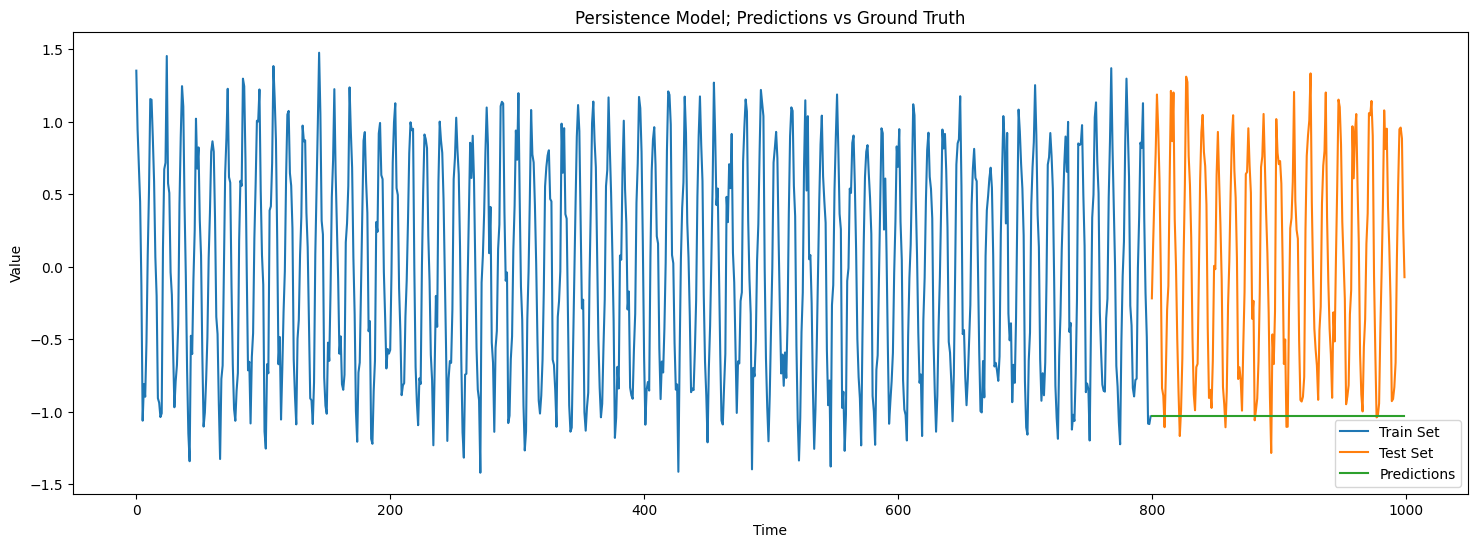

In [35]:
predictions = [train_df.values[-1]] * len(test_set)
rmse = np.sqrt(mean_squared_error(test_df.values, predictions))
print('Test RMSE: %.3f' % rmse)

plot_and_validate(train_df, test_df, predictions, "Persistence Model")

# Simple Moving Average Demonstration
Demonstrate the use of Simple Moving Average in time series forecasting.

**** Test RMSE [SMA Model]: 0.747 ****


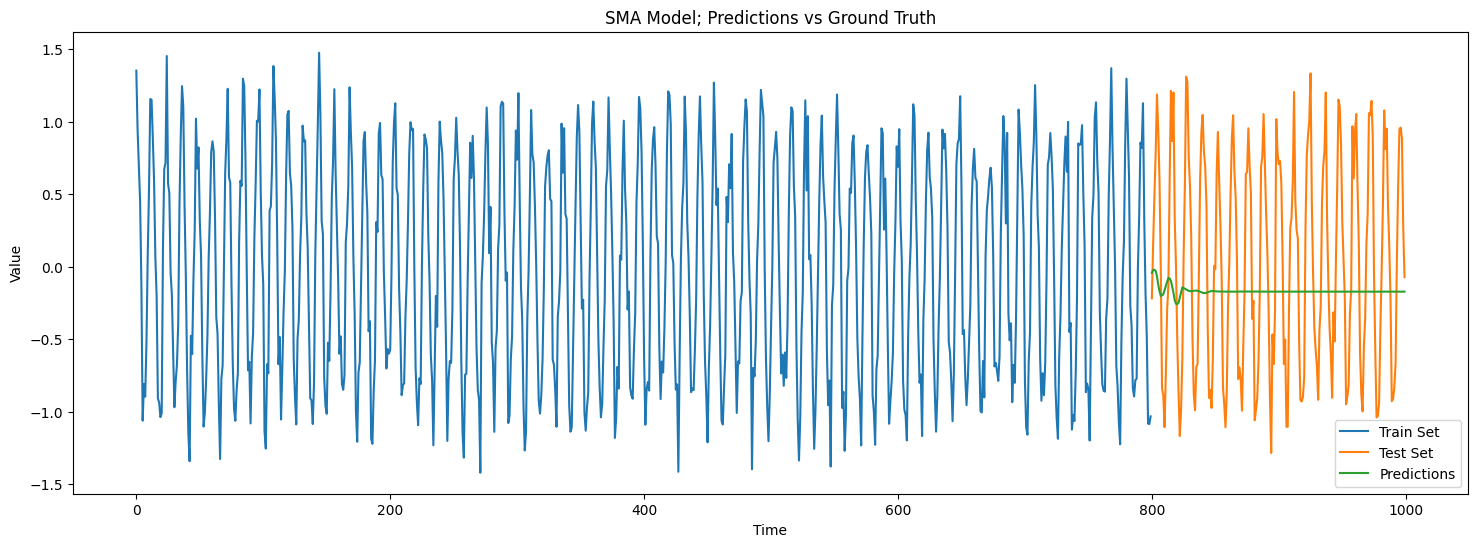

In [36]:
# Simple Moving Average model
def model_sma(history: list, window_size: int) -> float:
    return np.mean(history[-window_size:])

# Walk-forward validation for SMA
predictions_sma = []
history = train_df['value'].values.tolist()

for i in range(len(test_df)):
    # Predict and append to predictions
    yhat = model_sma(history, 24)
    predictions_sma.append(yhat)
    
    # Add actual observation to history for the next loop
    history.append(yhat)

plot_and_validate(train_df, test_df, predictions_sma, "SMA Model")

# Exponential Smoothing Demonstration
Demonstrate the use of Exponential Smoothing in time series forecasting.

**** Test RMSE [Exponential Smoothing Model]: 0.771 ****


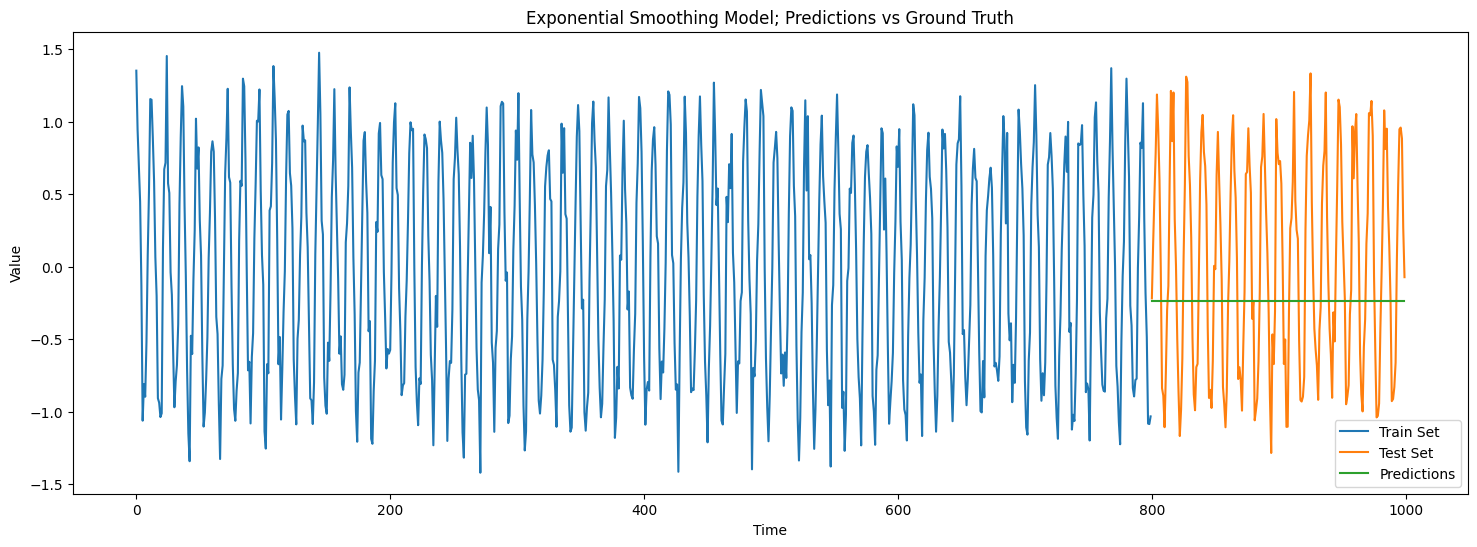

In [37]:
model = SimpleExpSmoothing(train_df['value'])
model_fit = model.fit(smoothing_level=0.1, optimized=False)

# Make prediction
yhat = model_fit.forecast(len(test_df))

# Walk-forward validation for Exponential Smoothing
predictions_exp = []
history = train_df['value'].values.tolist()

for i in range(len(test_df)):
    # Predict and append to predictions
    yhat = model_fit.predict(len(history), len(history))
    predictions_exp.append(yhat)
    
    # Add actual observation to history for the next loop
    history.append(test_df['value'].values[i])

plot_and_validate(train_df, test_df, predictions_exp, "Exponential Smoothing Model")

# ARIMA and SARIMA Demonstration
Demonstrate the use of ARIMA and SARIMA models in time series forecasting.

c:\Users\aleja\workspace\SERTEMP-project-MAADM-UPM\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


**** Test RMSE [ARIMA Model]: 0.261 ****


c:\Users\aleja\workspace\SERTEMP-project-MAADM-UPM\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


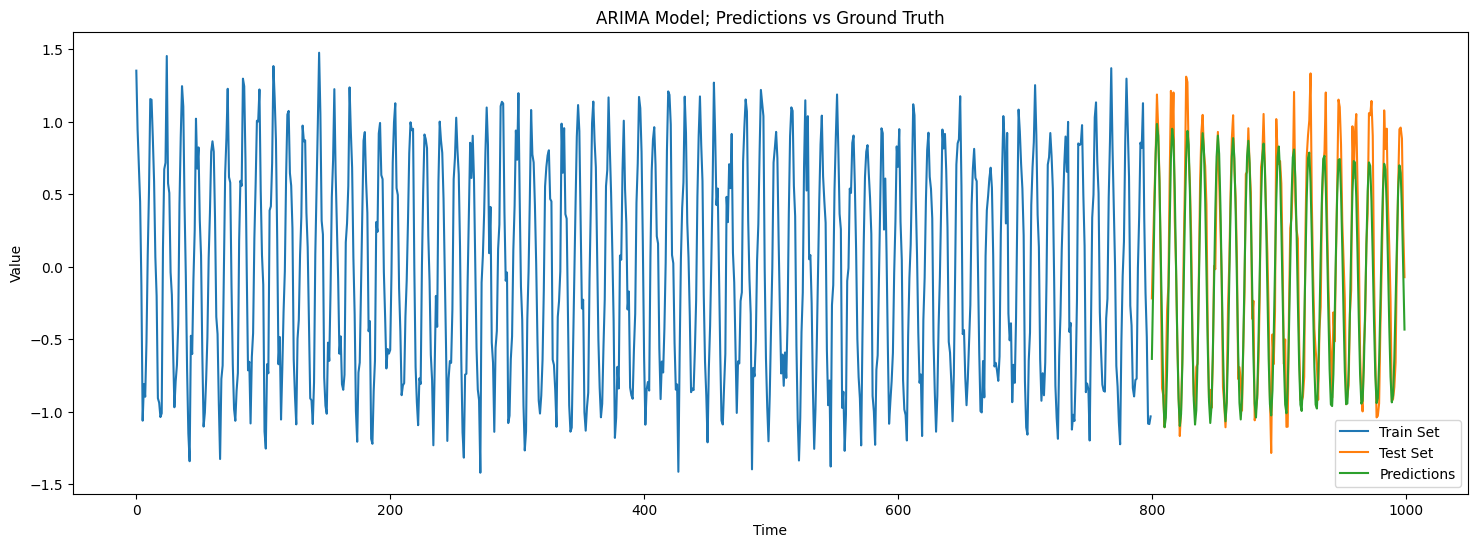

**** Test RMSE [SARIMA Model]: 0.236 ****


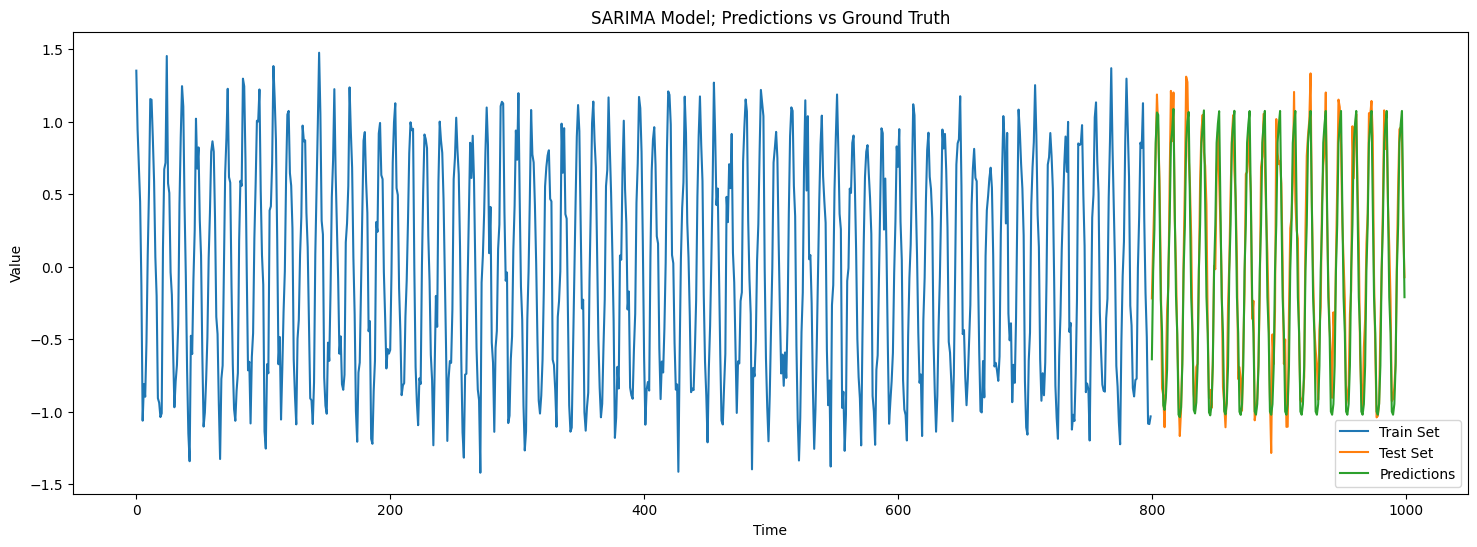

In [38]:
model_arima = ARIMA(train_df['value'], order=(3,2,10))
model_arima_fit = model_arima.fit()
predictions_arima = model_arima_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1)
plot_and_validate(train_df, test_df, predictions_arima, "ARIMA Model")

model_sarima = SARIMAX(train_df['value'], order=(1,0,1), seasonal_order=(1, 1, 0, 12))
model_sarima_fit = model_sarima.fit()
predictions_sarima = model_sarima_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1)
plot_and_validate(train_df, test_df, predictions_sarima, "SARIMA Model")

# Prophet Demonstration
Demonstrate the use of Prophet in time series forecasting.

22:12:06 - cmdstanpy - INFO - Chain [1] start processing
22:12:06 - cmdstanpy - INFO - Chain [1] done processing


**** Test RMSE [Prophet Model]: 0.228 ****


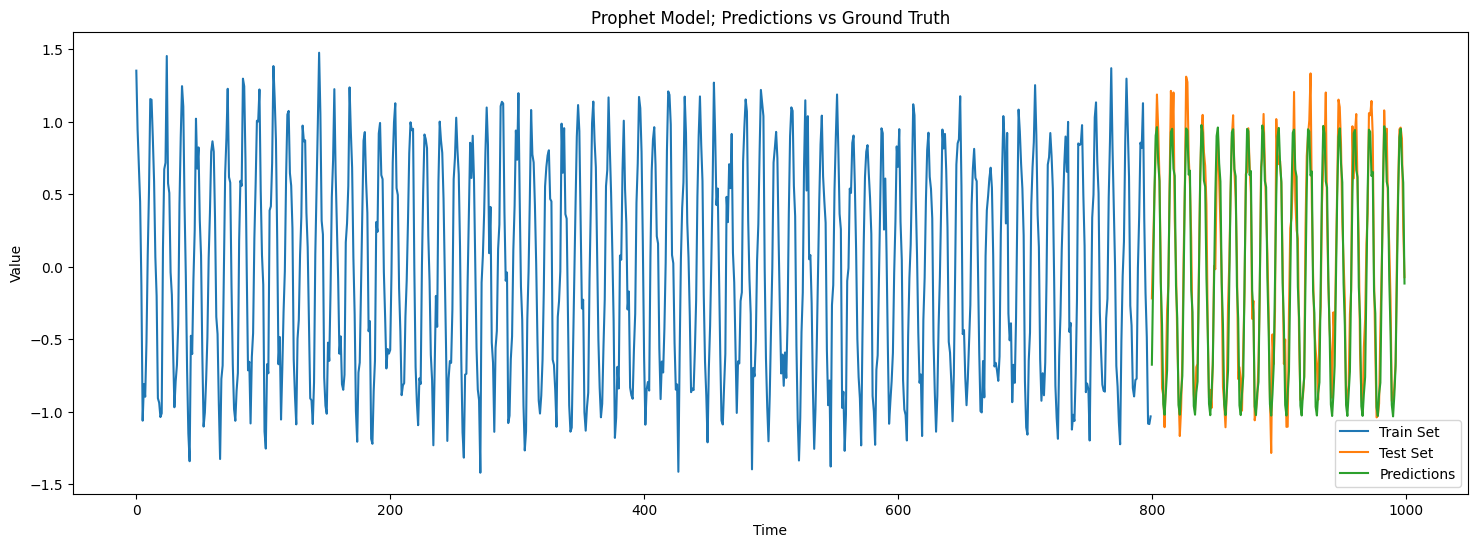

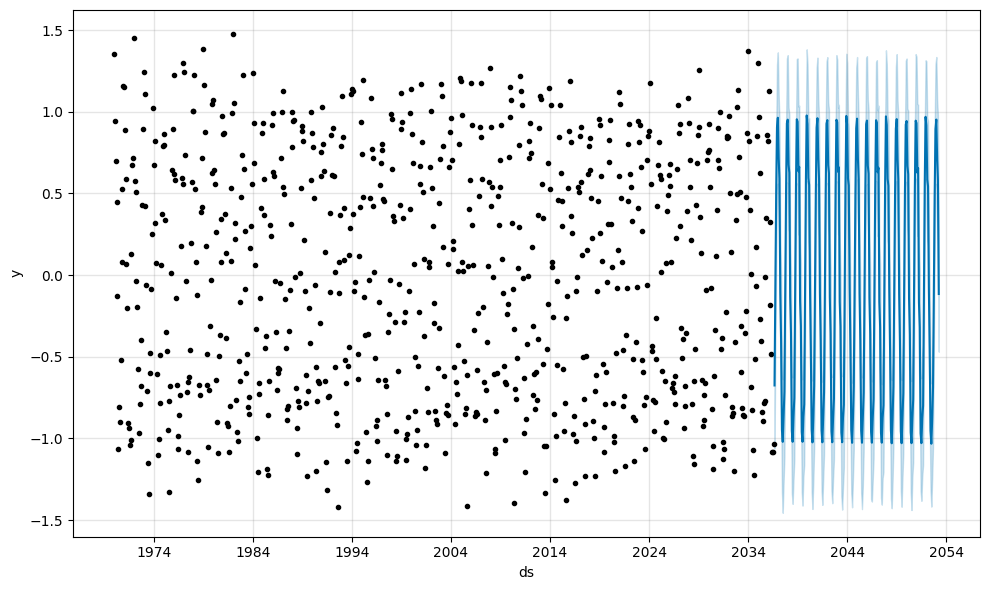

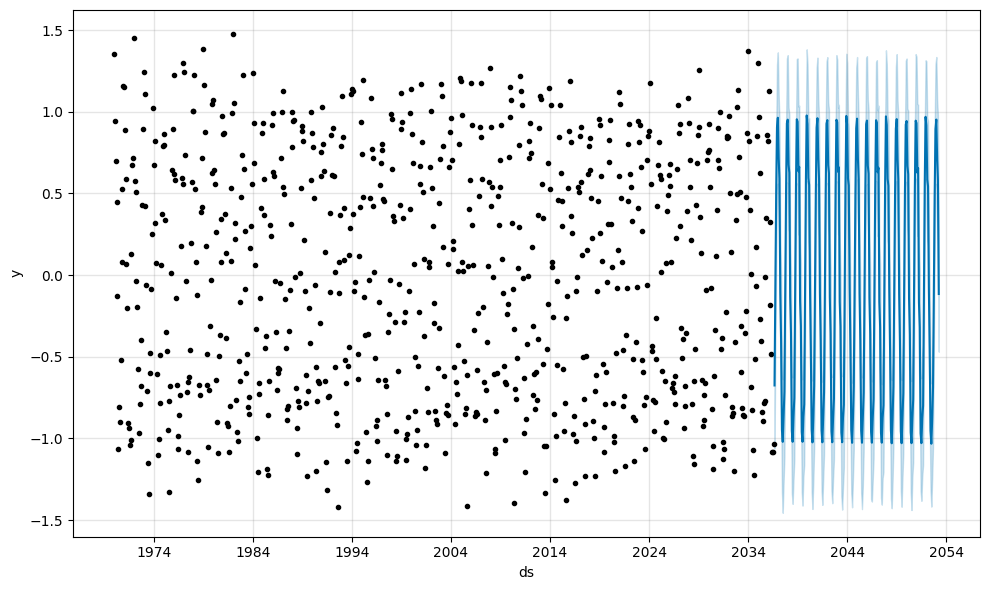

In [41]:
model_prophet = Prophet(interval_width=0.95)
new_df = train_df.copy().reset_index().rename(columns={'index':'ds', 'value':'y'})
new_df['ds'] = pd.to_datetime(new_df['ds'], unit='M')

model_prophet.fit(new_df)
# Make Future Dataframe
future = model_prophet.make_future_dataframe(periods=len(test_df), freq='ME', include_history=False)
forecast = model_prophet.predict(future)

# Extract Predicted Values
predictions_prophet = forecast['yhat'].values[-len(test_df):]

# Calculate RMSE for Prophet
rmse_prophet = np.sqrt(mean_squared_error(test_df, predictions_prophet))
plot_and_validate(train_df, test_df, predictions_prophet, "Prophet Model")

# Use the plot with confidence intervals
model_prophet.plot(forecast)

# Vector Autoregression Demonstration
VAR is used for multivariate time series, we define a second new variable to perform forecasting on the first one.

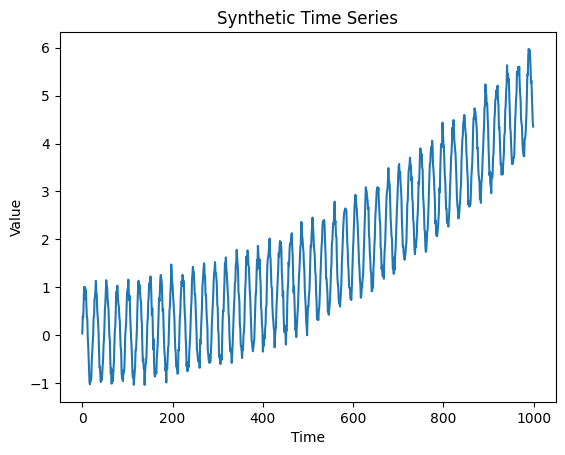

In [42]:
trend_coeff = 5e-6
seasonality_period = 24
noise_std = 0.1
n_samples = 1000

# Generate the time index
t = np.arange(n_samples)

# Generate the quadratic ascending trend
trend = trend_coeff * t**2

# Generate the sine seasonality
seasonality = np.sin(2* np.pi * t / seasonality_period)

# Generate the random noise
noise = np.random.normal(0, noise_std, n_samples)

# Generate the synthetic time series
time_series = trend + seasonality + noise

# Assuming your synthetic time series is stored in the variable 'data'
plt.plot(time_series)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Synthetic Time Series')
plt.show()

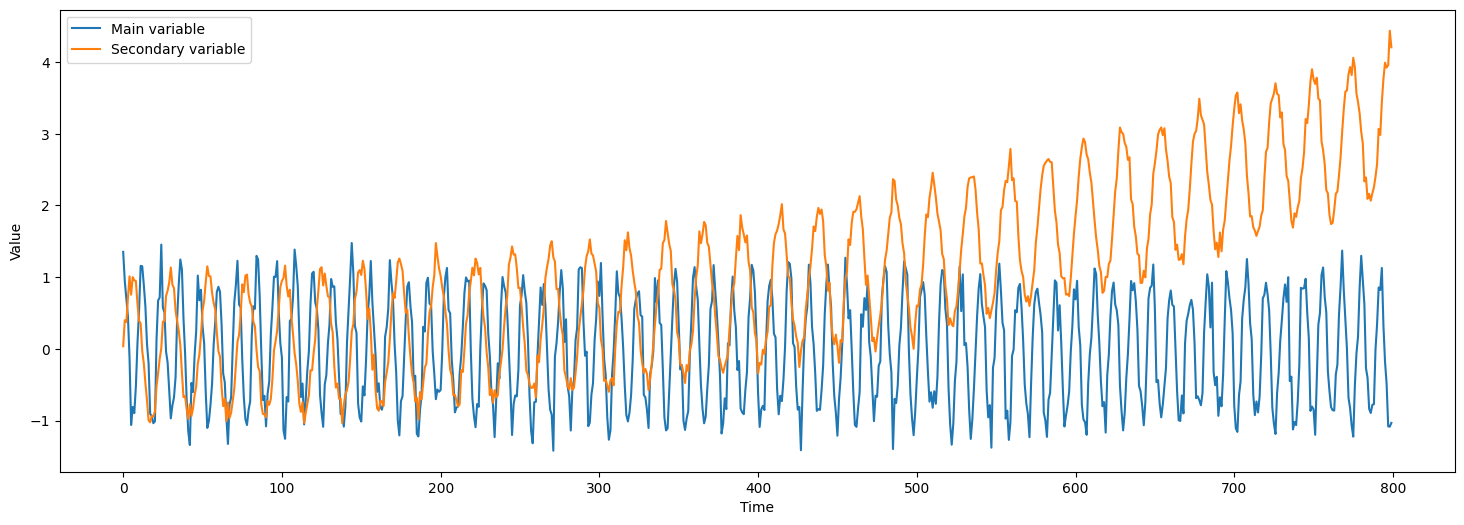

In [45]:
train_set = time_series[:split_index]
test_set = time_series[split_index:]

train_df['aux_value'] = train_set
test_df['aux_value'] = test_set

# Plot synthetic multi-variate time series
plt.figure(figsize=(18,6))
plt.plot(train_df['value'], label='Main variable')
plt.plot(train_df['aux_value'], label='Secondary variable')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

**** Test RMSE for value: 0.223 ****
**** Test RMSE for aux_value: 0.771 ****


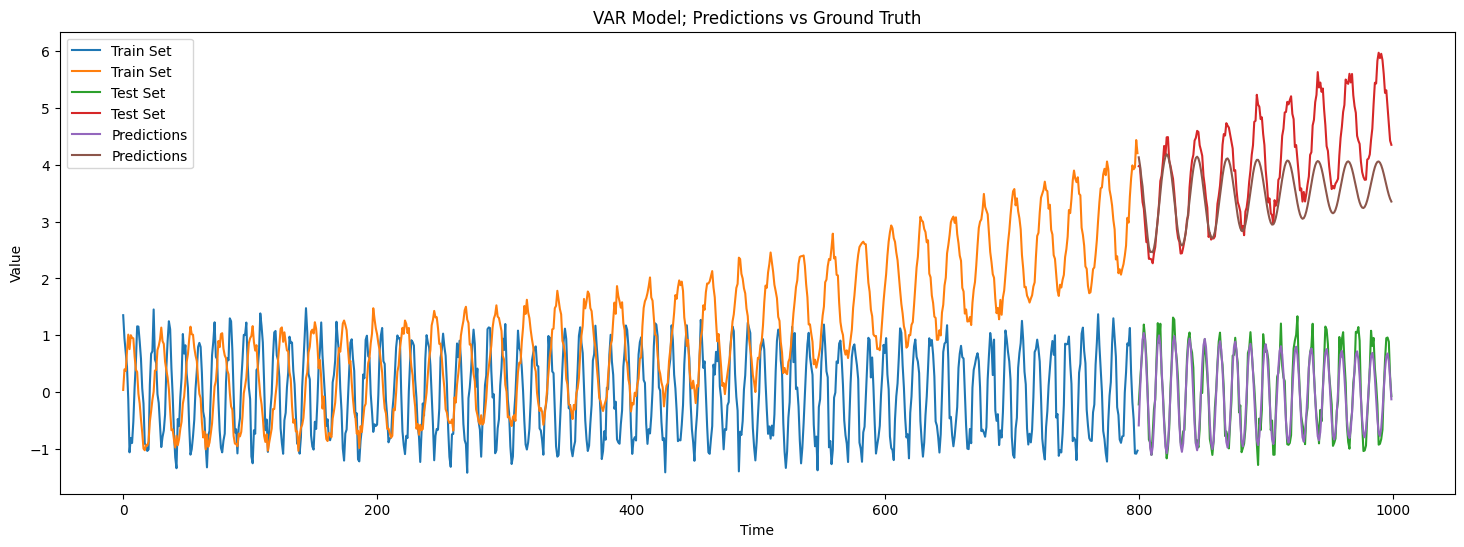

In [47]:
# Normalize features to a range
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.values)
test_scaled = scaler.transform(test_df.values)

# Convert to DataFrame
train_scaled = pd.DataFrame(train_scaled, columns=train_df.columns)
test_scaled = pd.DataFrame(test_scaled, columns=test_df.columns)

# Fit the model
model = VAR(endog=train_scaled)
model_fit = model.fit(maxlags=12) # maxlags is the maximum number of lags to consider, use 24 to fix the issue

# Make prediction
prediction = model_fit.forecast(model_fit.endog, steps=len(test_df))

# Invert transformation
prediction = scaler.inverse_transform(prediction)
plot_and_validate(train_df, test_df, prediction, "VAR Model")

# Random Forest Demonstration
Any ML regressor can be used to forecast

***** Tiempo entrenamiento Random Forest: 0 minutos 16 segundos *****
**** Test RMSE for value: 0.450 ****
**** Test RMSE for aux_value: 0.990 ****


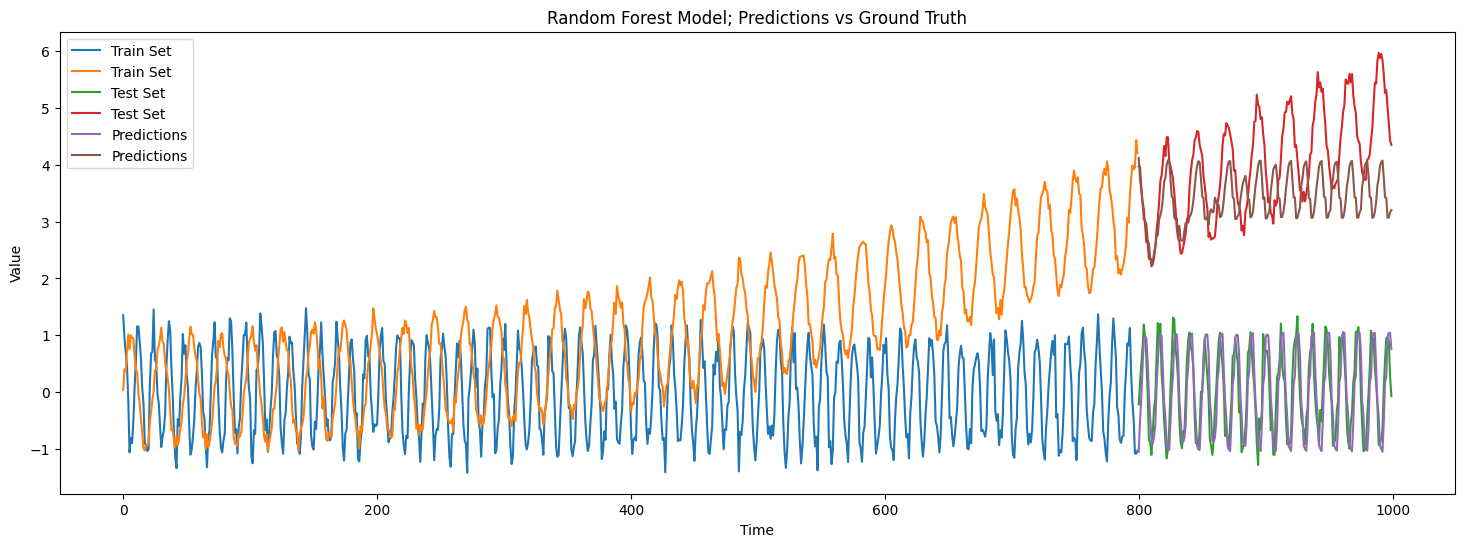

In [51]:
model_rf = RandomForestRegressor(n_estimators=500, random_state=0)

sliding_window = 48
slide_train_df = pd.DataFrame()
for i in range(sliding_window+1):
    for column in train_df.columns:
        slide_train_df[f'{column}-{i}'] = train_scaled[column].shift(i)

slide_train_df.dropna(inplace=True)
slide_train_df_shuffled = slide_train_df.sample(frac=1, random_state=0)
slide_train_df_x = slide_train_df_shuffled.iloc[:,2:]
slide_train_df_y = slide_train_df_shuffled.iloc[:,:2]

start = time.time()
model_rf.fit(slide_train_df_x.values, slide_train_df_y.values)
minutos, segundos = divmod(time.time() - start, 60)
print(f"***** Tiempo entrenamiento Random Forest: {int(minutos)} minutos {int(segundos)} segundos *****")

# Generate predictions
test_inputs = slide_train_df.iloc[-1, 2:].values.reshape(1, -1)
prediction_rf = []
for i in range(len(test_df)):
    prediction = model_rf.predict(test_inputs)
    prediction_rf.append(prediction)
    test_inputs = np.roll(test_inputs, 2)
    test_inputs[0, :2] = prediction

prediction_rf = scaler.inverse_transform(np.array(prediction_rf).reshape(-1, 2))
plot_and_validate(train_df, test_df, prediction_rf, "Random Forest Model")

# LSTM Model Demonstration
Demonstrate the use of LSTM model (with PyTorch) in time series forecasting.

In [59]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.reset_hidden_cell()

    def reset_hidden_cell(self) -> None:
        self.hidden_cell = (torch.zeros(1,self.hidden_layer_size),
                            torch.zeros(1,self.hidden_layer_size))
        
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        return self.linear(lstm_out)

# Prepare data for LSTM
train_data_normalized = torch.FloatTensor(train_scaled.values).view(-1, 2)

# Define a method to create in-out sequences
def create_inout_sequences(input_data: torch.Tensor, wz: int) -> list:
    inout_seq = []
    L = len(input_data)
    for i in range(L-wz):
        train_seq = input_data[i:i+wz-1]
        train_label = input_data[i+1:i+wz]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

# Create in-out sequences
window_size = 12
train_inout_seq = create_inout_sequences(train_data_normalized, window_size)

# Initialize the model, define loss and optimization functions
model = LSTM(input_size=2, hidden_layer_size=50, output_size=2)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 100
trace = 10
loss_history = []
rmse_history = []

start = time.time()
for i in range(epochs):
    epoch_loss = 0
    rmse = 0
    random.shuffle(train_inout_seq) # Randomize the training data
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.reset_hidden_cell()
        y_pred = model(seq)

        single_loss = loss_function(y_pred.squeeze(), labels)
        single_loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            epoch_loss += single_loss/len(train_inout_seq)
            rmse += np.sqrt(mean_squared_error(scaler.inverse_transform(labels.detach().numpy()), 
                                              scaler.inverse_transform(y_pred.squeeze().detach().numpy()))
                        )/len(train_inout_seq)
    
    loss_history.append(epoch_loss)
    rmse_history.append(rmse)

    if i % trace == 0:
        print(f'Epoch {i} loss: {epoch_loss}. RMSE: {rmse}')

minutos, segundos = divmod(time.time() - start, 60)
print(f"***** Tiempo entrenamiento LSTM: {int(minutos)} minutos {int(segundos)} segundos *****")

Epoch 0 loss: 0.22159674763679504. RMSE: 0.39377453923225403
Epoch 10 loss: 0.07361099869012833. RMSE: 0.21742448210716248
Epoch 20 loss: 0.06810258328914642. RMSE: 0.208197683095932
Epoch 30 loss: 0.06334985047578812. RMSE: 0.20062954723834991
Epoch 40 loss: 0.05862952768802643. RMSE: 0.1931258589029312
Epoch 50 loss: 0.054079923778772354. RMSE: 0.18567168712615967
Epoch 60 loss: 0.049181170761585236. RMSE: 0.17701615393161774
Epoch 70 loss: 0.045560073107481. RMSE: 0.1701483577489853
Epoch 80 loss: 0.04311751201748848. RMSE: 0.16526396572589874
Epoch 90 loss: 0.04089859127998352. RMSE: 0.16063880920410156
***** Tiempo entrenamiento LSTM: 2 minutos 36 segundos *****


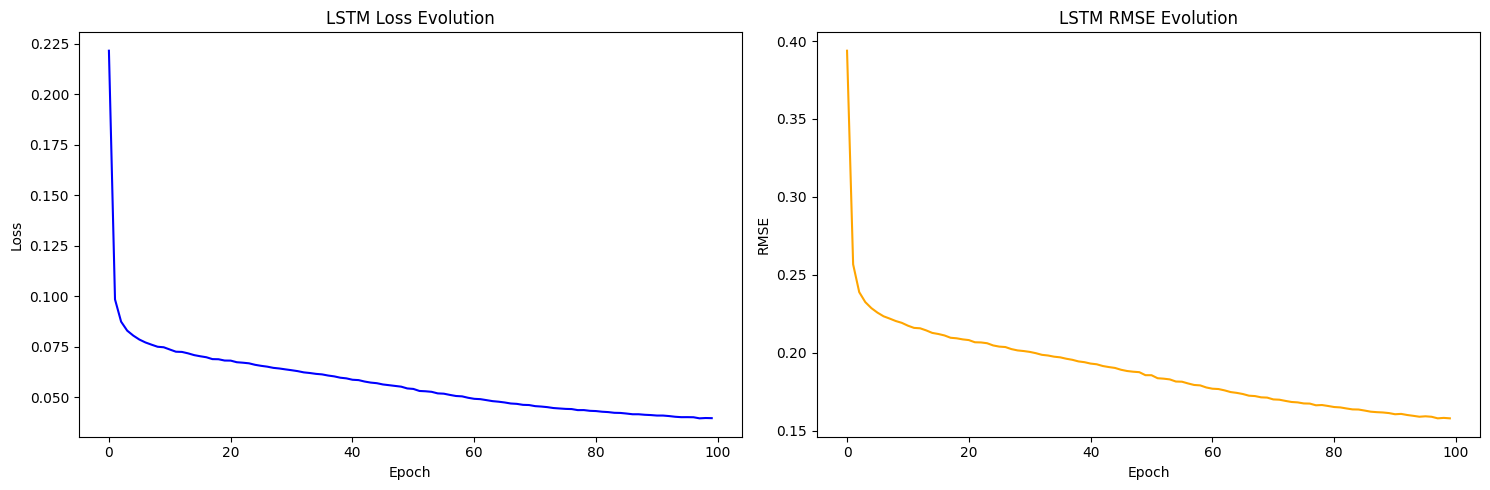

In [64]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history, color='blue')
plt.title('LSTM Loss Evolution')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(rmse_history, color='orange')
plt.title('LSTM RMSE Evolution')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.tight_layout()
plt.show()

100%|██████████| 200/200 [00:00<00:00, 4624.85it/s]

**** Test RMSE for value: 0.556 ****
**** Test RMSE for aux_value: 1.075 ****


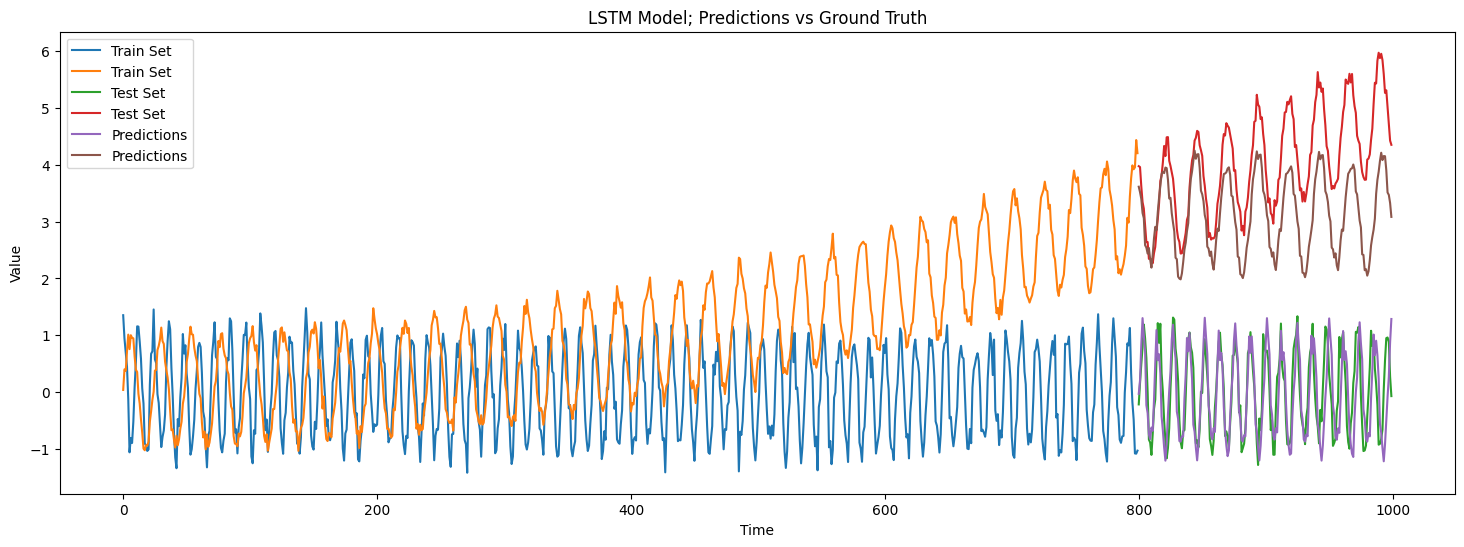

In [65]:
# Evaluation
fut_pred = len(test_scaled)
test_inputs = train_data_normalized[-window_size:].tolist()
predictions = []
model.eval()
with torch.no_grad():
    model.reset_hidden_cell()
    seq = torch.FloatTensor(test_inputs[-window_size:])
    output = model(seq)[-1].unsqueeze(0)
    test_inputs.append(output.numpy())

    for i in tqdm(range(fut_pred)):
        output = model(output)
        test_inputs.append(output[-1].numpy())

# Invert transformations
actual_predictions = scaler.inverse_transform(np.array(test_inputs[-fut_pred:]).reshape(-1, 2))
plot_and_validate(train_df, test_df, actual_predictions, "LSTM Model")